## Lecture 11: Structural equation modeling

In this lecture we will focus on the estimation of parameters for SEM models.  We will use the *lavaan* R package for SEM analysis - there are Python-based packages, but they are not as widely accepted as lavaan. This will also highlight the utility of the R-to-Python bridge provided by Jupyter and the rpy2 package.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML
import rpy2
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

import seaborn as sns

%load_ext rpy2.ipython

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## Linear regression

We will start by showing how one can estimate a simple linear regression model using SEM.  We will use simulated data so that we know the ground truth.

First, let's generate some data.

,x,Y
x,1.000000,0.419066
Y,0.419066,1.000000


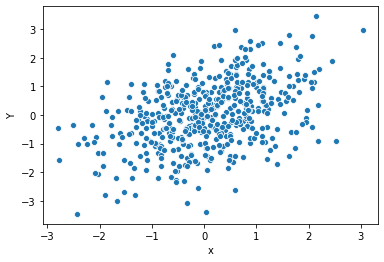

In [2]:
npts = 500
noise_sd = 1
rng = np.random.RandomState(1)
simdataDf = pd.DataFrame({'x': rng.randn(npts)})
beta = np.array([0.5])
simdataDf['Y'] = simdataDf.dot(beta) + np.random.randn(npts)*noise_sd

sns.scatterplot(x='x', y='Y', data=simdataDf)
simdataDf.corr()

In [3]:
# estimate linear regression model

X = sm.add_constant(simdataDf[['x']])
y = simdataDf['Y']
model = sm.OLS(y, X)
ols_results = model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     106.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.10e-22
Time:                        14:14:50   Log-Likelihood:                -714.71
No. Observations:                 500   AIC:                             1433.
Df Residuals:                     498   BIC:                             1442.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0236      0.045     -0.521      0.6

Now let's build a structural model for this analysis using lavaan.

In [4]:
%%R -i simdataDf -o results

library(lavaan)
myModel <- ' # regressions
             Y ~ x
    
             # variances and covariances 
             Y ~~ Y 

             # intercepts 
             Y~ 1 
           '

fit <- lavaan(myModel, data=simdataDf)
summary(fit, standardized=TRUE)

results = list(fitted = fitted(fit)$cov,
              resid = resid(fit)$cov,
              coefs = coef(fit))

R[write to console]: This is lavaan 0.6-5

R[write to console]: lavaan is BETA software! Please report any bugs.



lavaan 0.6-5 ended normally after 11 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          3
                                                      
  Number of observations                           500
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  Y ~                                                                   
    x                 0.472    0.046   10.321    0.000    0.472    0.419

Intercepts:

R[write to console]: Registered S3 methods overwritten by 'huge':
  method    from   
  plot.sim  BDgraph
  print.sim BDgraph



$cov
  Y     x    
Y 1.239      
x 0.461 0.977

$mean
    Y     x 
0.002 0.053 



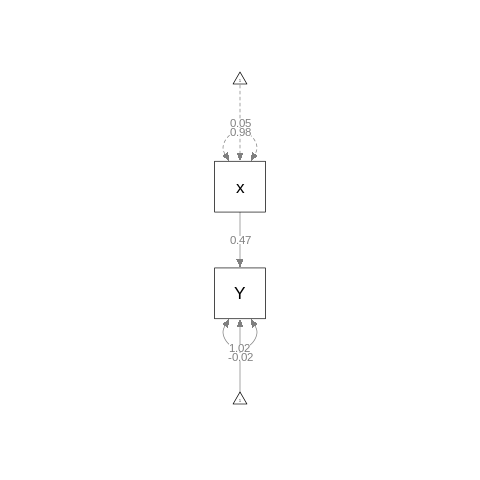

In [5]:
%%R
library(semPlot)

semPaths(fit, "model", "est", rotation=1, sizeMan =10, sizeMan2 = 10, 
        edge.label.cex = 1)

fitted(fit)

As you can see, the estimated parameters from SEM are the same as the regression model. However, the standard errors are very slightly different (not noticable to the third decimal place in this case) - this is because the OLS regression estimates using the unbiased estimator for the variance (with N-1 in the denominator), whereas SEM uses maximum likelihood which is a biased estimator of the variance (with N in the denominator).  These differences are minor unless the sample size is very small.



## Estimating SEM parameters

We saw in the earlier session on regression how those parameters are estimated using least squares.  SEM models are estimated in a different way.  Most importantly, the main difference between SEM and regression is the loss function: Whereas in linear regression we used the sum of squared errors between the predicted and estimated values for the data points, in SEM we use the sum of squared differences between the observed covariance and the covariance predicted by the model. For this reason, these models are often referred to as "covariance structure models".

The observed covariance between all measured variables serves as our estimate of the population covariance, which we simply plug into the loss function.  We compare this to the covariance matrix that is implied by any specific set of parameter values. 

Let's see how this works for the simple regression example, where we only have a single parameter.  The implied covariance matrix here is:

$$
\left[ \begin{array}{cc}
\sigma^2_x & \text{cov}(x\beta_1, y) \\
\text{cov}(x\beta_1, y)& \sigma^2_y \\
\end{array} \right]$$


In [6]:
S = simdataDf.cov().values
print('observed covariance')
print(S)

observed covariance
[[0.9789087  0.46192708]
 [0.46192708 1.24119536]]


Let's create a function to generate the implied covariance from this dataset, given a specific value of $\beta_1$:

In [7]:
def get_implied_cov(dataDf, beta):
    # get observed cov
    observed = np.cov(dataDf.values.T)
    # get diagonal from observed
    sigma = np.zeros(observed.shape)
    sigma[np.diag_indices_from(observed)] = np.diag(observed)
    
    # get implied 
    sigma[0, 1] = np.cov(dataDf.x*beta, dataDf.x)[0, 1]
    sigma[1, 0] = sigma[0, 1]
    return(sigma)

sigma = get_implied_cov(simdataDf, ols_results.params.x)
print('model-implied covariance')
print(sigma)

model-implied covariance
[[0.9789087  0.46192708]
 [0.46192708 1.24119536]]


In this case the model-implied differs from the observed covariance matrix at one location (since the variances of x and y remain the same), which is the covariance of predicted values (using $\beta_1$) with the observed values.

## Loss function

Why are we worried about covariances?  Because whereas the squared error loss for ordinary least squares compares the predicted and observed *data*, the loss function for structural equation modeling compares the predicted and observed *covariances*.  Here is the loss function that is used for maximum likelihood estimation (rearranged from Bollen, 1989):

$$
loss = log |\Sigma| - log|\textbf{S}| + tr(\textbf{S}\Sigma^{-1}) - (p + q)
$$

where:

- $log |\Sigma|$ is the log determinant of the implied covariance matrix 
- $log |\textbf{S}|$ is the log determinant of the observed covariance matrix 
- $tr(\textbf{S}\Sigma^{-1})$ is the trace of a matrix obtained by multiplying the observed covariance matrix by the inverse of the implied covariance matrix - basically this is a sum of the ratios of the observed and implied variances; in a simple model like this one, it is simply the number of variables, since the implied and observed variances are identical.
- p is the number of endogenous (dependent) variables
- q is the number of exogenous (independent) variables

Why do we take the determinant of the covariance matrix?  This basically tells us how dispersed our data are. Remember that the determinant of a 2 x 2 matrix:

$$
x = \left[ \begin{array}{cc}
a & b \\
c & d \\
\end{array} \right]
$$

is:

$$
|x| = a*d - b*c
$$

In the case of a covariance matrix, $a$ and $d$ are the variances, and $b$ and $c$ are the covariance, so the determinant is effectively the product of the variances minus the square of the covariance.  Also note that the determinant of a covariance matrix is always positive because the covariance matrices are positive definite. Thus, the determinant will be zero if the covariance is one, whereas the determinant will be maximal when the covariance is zero, and minimal (zero) when the correlation is perfect (either positive or negative):

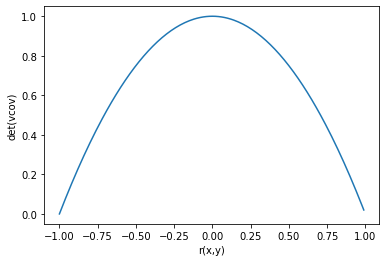

In [8]:
nruns=1000
npts=100
detsimDf = pd.DataFrame({'r': np.arange(-1, 1, 0.01)})

for i in range(detsimDf.shape[0]):
    corr = detsimDf.r[i]
    vcov = np.array([[1, corr], [corr, 1]])
    detsimDf.loc[i, 'det'] = np.linalg.det(vcov)
    
plt.plot(detsimDf.r, detsimDf.det)
plt.xlabel('r(x,y)')
plt.ylabel('det(vcov)')
plt.savefig('det_vs_corr.pdf')


We see that the determinant is at its minimum when the data are perfectly correlated (assuming that the variances of x and y are held constant); in the context of modeling, this means that the better our model, the more of the variance in the data we capture and thus the smaller the difference between the log determinant of the model-implied covariance and the sample covariance.  

Now let's generate a function to compute the loss, given particular implied and observed covariance functions:

In [9]:
def sem_loss(observed, implied, verbose=False):
    """
    compute loss for SEM
    
    parameters:
    -----------
    observed: observed 
    """
    log_det_implied = np.log(np.linalg.det(implied) )
    if verbose:
        print('log(det) for implied:', log_det_implied)
    cov_ratio_trace = np.trace(observed.dot(np.linalg.inv(implied)))
    if verbose:
        print('trace of variance ratios:', cov_ratio_trace)
    log_det_observed = np.log(np.linalg.det(observed))
    if verbose:
        print('log(det) for observed:', log_det_observed)
    loss = log_det_implied + cov_ratio_trace - log_det_observed - observed.shape[0]
    return(loss)

sem_loss(S, sigma, verbose=True)

log(det) for implied: 0.001638974464217008
trace of variance ratios: 2.0000000000000004
log(det) for observed: 0.0016389744642172296


4.440892098500626e-16

Now let's try various values for the regression parameter and compute their loss:

Parameter with minimum loss: 0.4718796334248379
OLS estimate of parameter: 0.4718796334248378


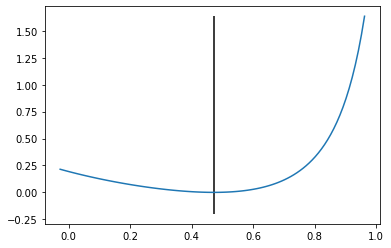

In [10]:
offset = 0.5
params = np.arange(ols_results.params.x - offset, ols_results.params.x + offset, 0.01)
loss_values = np.zeros(params.shape[0])
for i, beta in enumerate(params):
    sigma = get_implied_cov(simdataDf, beta)
    loss_values[i] = sem_loss(S, sigma)
    
plt.plot(params, loss_values)
plt.vlines(ols_results.params.x, ymin=np.min(loss_values) - 0.2, ymax=np.max(loss_values))
print('Parameter with minimum loss:', params[np.argmin(loss_values)])
print('OLS estimate of parameter:', ols_results.params.x)

assert np.allclose(params[np.argmin(loss_values)], ols_results.params.x)

## Confirmatory factor analysis

One common use of structural equation modeling is for the estimation of *confirmatory factor analysis* models.  These models include a set of *indicator* variables, which reflect observed measurements.  Each indicator in a standard CFA model has two latent inputs: a single *factor* which is measured by that indicator, and an *error* term that represents the unique sources of variance for that indicator.  There can be multiple factors, which are allowed to correlate with one another.  

For standard CFA models (in which each observed variable is associated with a single latent factor), the identification requirements are simple: for a single factor there must be three indicators, and for two or more factors each factor must be associated with at least two indicators.

As an example, we will use the SRO dataset to fit a CFA model with three factors:

- Self-control: measured by MPQ (control), BIS-11 (nonplanning), and Brief Self Control (self-control)
- Working memory: measured by adaptive n-back (mean load), Raven's progressive matrices (overall score), and spatial span (reverse span)
- Risk-taking: measured by UPPS-P (sensation seeking), Impulsive-Venturesomeness Survey (venturesomeness), and DOSPERT (recreational risk taking)

First we set up the data and plot them.

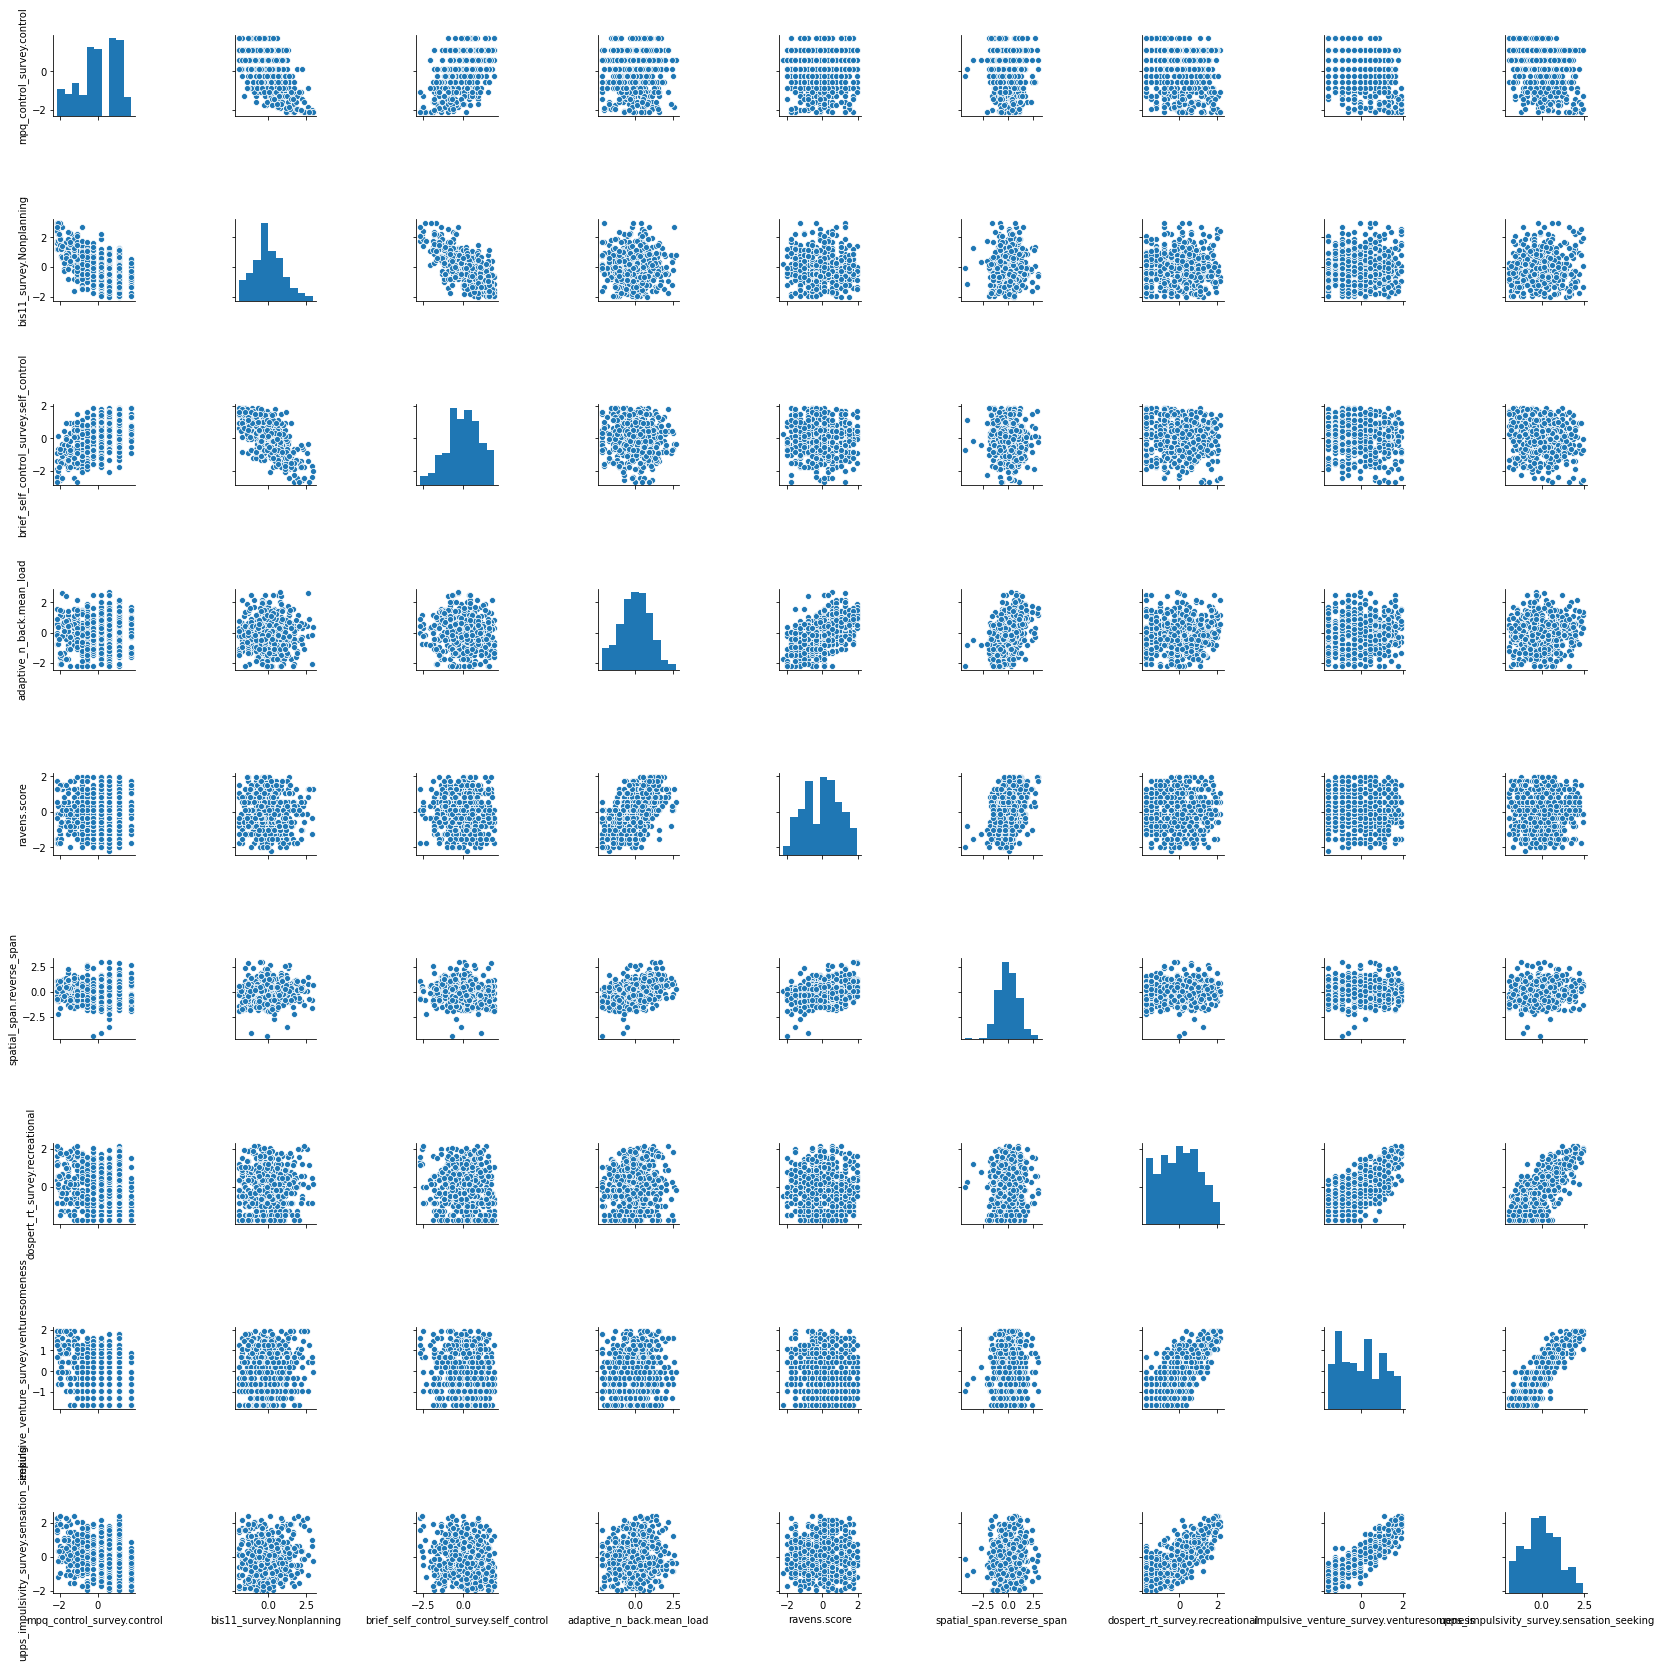

In [11]:
from data_utils import get_SRO_data
import scipy.stats

SRO_data = get_SRO_data()
cfadata = SRO_data[['mpq_control_survey.control',
                    'bis11_survey.Nonplanning',
                    'brief_self_control_survey.self_control',
                    'adaptive_n_back.mean_load',
                    'ravens.score',
                    'spatial_span.reverse_span',
                    'dospert_rt_survey.recreational',
                    'impulsive_venture_survey.venturesomeness',
                    'upps_impulsivity_survey.sensation_seeking']]
                    
                    
cfadata = cfadata.dropna()
# transform some badly distributed variables
vars_to_transform = ['mpq_control_survey.control',
                    'adaptive_n_back.mean_load',
                    'dospert_rt_survey.recreational',
                    'impulsive_venture_survey.venturesomeness']
for v in vars_to_transform:
    cfadata.loc[:,v] = scipy.stats.boxcox(cfadata.loc[:,v] + 1)[0]
# scale the data to make interpretation of covariances easier
cfadata = (cfadata - cfadata.mean(0))/cfadata.std(0)

# It's always a good idea to look at the data...
sns.pairplot(cfadata)

None of these are terribly non-Gaussian, so we will forge ahead. Let's set up the model in lavaan:


In [12]:
%%R -i cfadata

cfa_3factor.model <- 'IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
'

fit_3factor <- cfa(cfa_3factor.model, data=cfadata)

summary(fit_3factor)

lavaan 0.6-5 ended normally after 28 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         21
                                                      
  Number of observations                           504
                                                      
Model Test User Model:
                                                      
  Test statistic                                87.004
  Degrees of freedom                                24
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Information                                 Expected
  Information saturated (h1) model          Structured
  Standard errors                             Standard

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  IMP =~                                              
    mpq_cntrl_srv.    1.000                           
    bs

Create a plot showing the model parameters.

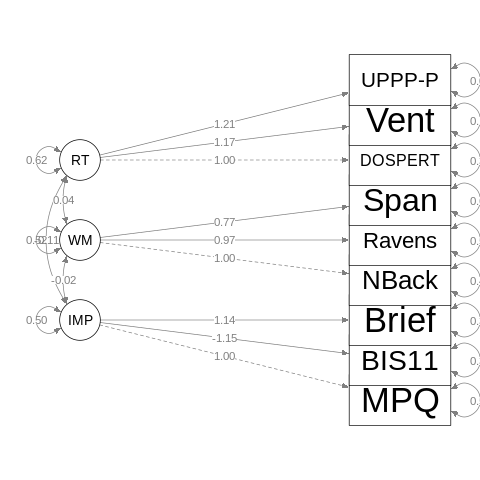

In [13]:
%%R

varnames = c('MPQ', 'BIS11', 'Brief', 'NBack', 'Ravens', 
             'Span', 'DOSPERT', 'Vent','UPPP-P', "IMP" ,"WM",  "RT" )

semPaths(fit_3factor, "model", "est", 
         rotation=2, sizeMan =20, sizeMan2 = 10, 
         nodeLabels=varnames, edge.label.cex = 1)

fit_residuals = resid(fit_3factor)$cov

We can look at each of the components in the loss function:

loss =  0.1726444460352461
loss estimated by lavaan: 0.17262668320657326


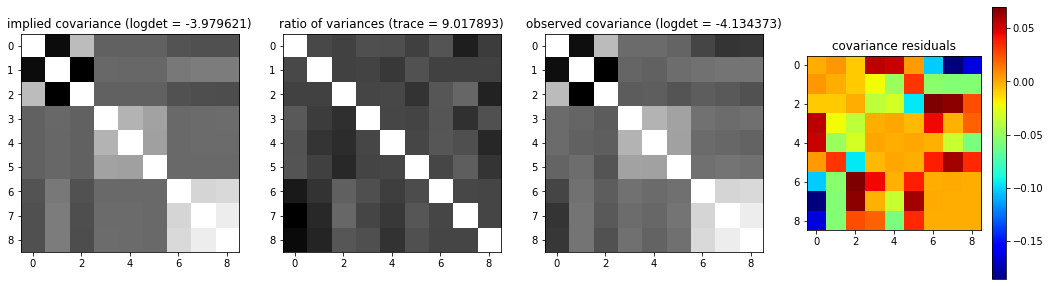

In [33]:
observed = cfadata.cov()
implied = r('fitted(fit_3factor)$cov')

plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.imshow(implied, interpolation='nearest', cmap='gray')
plt.title('implied covariance (logdet = %f)' % np.log(np.linalg.det(implied)))

plt.subplot(1,4,2)
var_ratio = observed.dot(np.linalg.inv(implied))
plt.imshow(var_ratio, interpolation='nearest', cmap='gray')
plt.title('ratio of variances (trace = %f)' % np.trace(var_ratio))

plt.subplot(1,4,3)
plt.imshow(observed, interpolation='nearest', cmap='gray')
plt.title('observed covariance (logdet = %f)' % np.log(np.linalg.det(observed)))

plt.subplot(1,4,4)
plt.imshow(r['fit_residuals'], interpolation='nearest', cmap='jet')
plt.colorbar()
plt.title('covariance residuals')
 
print('loss = ', sem_loss(observed, implied))
# lavaan reports f_min which is f_ml/2
print('loss estimated by lavaan:', r("fitMeasures(fit_3factor, 'fmin')*2")[0])


Let's look a bit more closely at the matrices that go into generating the implied covariance matrix:

$$
\Sigma = \Lambda\Psi\Lambda' + \Theta
$$

where the $\Lambda$ matrix describes the mapping of measures to factors:



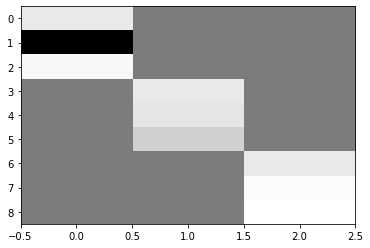

In [15]:
lmtx = r('inspect(fit_3factor,"est")$lambda')
plt.imshow(lmtx, aspect='auto', interpolation='nearest', cmap='gray')

The $\Phi$ matrix describes the variances and covariances of the latent factors:

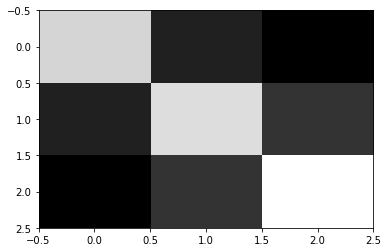

In [16]:
psimtx = r('inspect(fit_3factor,"est")$psi')
plt.imshow(psimtx, aspect='auto', interpolation='nearest', cmap='gray')

And the $\Theta$ matrix describes the error variance for the measurements:

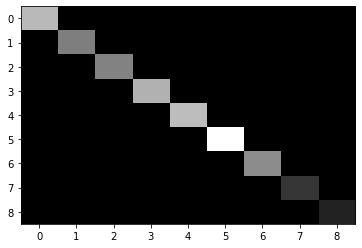

In [17]:
thetamtx = r('inspect(fit_3factor,"est")$theta')
plt.imshow(thetamtx, aspect='auto', interpolation='nearest', cmap='gray')

## Model fit testing

It is common in structural equation modeling to assess the global goodness of fit of the model using various fit measures. A common measure is Chi-squared testing of global model fit, which tests for deviations from exact fit of the model.  It is likely to be significant even for a useful model when the sample size is large, as it is here.  There are also a number of "fit indices" that are used by various researchers.  Reviewers will often insist on seeing these when one reports a result using SEM, and there are many different heuristic thresholds that different researchers in this field will insist upon.  One such heuristic is $\text{CFI} \ge 0.95$ and $\text{SRMR} \le .08$, which our model acheives:
    

In [18]:
%%R

summary(fit_3factor,header=FALSE, estimates=FALSE, fit.measures=TRUE)


Model Test Baseline Model:

  Test statistic                              2083.724
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.969
  Tucker-Lewis Index (TLI)                       0.954

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -5433.441
  Loglikelihood unrestricted model (H1)      -5389.939
                                                      
  Akaike (AIC)                               10908.881
  Bayesian (BIC)                             10997.555
  Sample-size adjusted Bayesian (BIC)        10930.899

Root Mean Square Error of Approximation:

  RMSEA                                          0.072
  90 Percent confidence interval - lower         0.056
  90 Percent confidence interval - upper         0.089
  P-value RMSEA <= 0.05                          0.012

Standardized Root Mean S

## Model comparison

One common use of CFA is to compare models; for example, let's compare our three-factor model above to a one-factor model.  The `compareFit()` function from semTools provides a useful set of model comparisons.

In [19]:
%%R

# fit a simpler one-factor model
cfa_1factor.model <- 'F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
'

fit_1factor <- cfa(cfa_1factor.model, data=cfadata)

library(semTools)

compareFit(fit_3factor, fit_1factor)

R[write to console]:  

R[write to console]: ###############################################################################

R[write to console]: This is semTools 0.5-2

R[write to console]: All users of R (or SEM) are invited to submit functions or ideas for functions.

R[write to console]: ###############################################################################



################### Nested Model Comparison #########################
Chi-Squared Difference Test

            Df   AIC   BIC   Chisq Chisq diff Df diff Pr(>Chisq)    
fit_3factor 24 10909 10998  87.004                                  
fit_1factor 27 11644 11720 828.194     741.19       3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

####################### Model Fit Indices ###########################
               chisq df pvalue   cfi   tli        aic        bic rmsea  srmr
fit_3factor  87.004† 24   .000 .969† .954† 10908.881† 10997.555† .072† .053†
fit_1factor 828.194  27   .000 .609  .478  11644.071  11720.078  .243  .186 

################## Differences in Fit Indices #######################
                          df   cfi    tli    aic     bic rmsea  srmr
fit_1factor - fit_3factor  3 -0.36 -0.476 735.19 722.522  0.17 0.133



### Bifactor models

Sometimes there may be a general factor that encompasses a set of more specific factors. These kinds of data are often modeled using a specific form of CFA known as a *bifactor model*, in which there are both specific factors (associated with particular measurement variables) as well as a general factor associated with all measurement variables. Let's fit such a model to our data.

In [22]:
%%R -i cfadata

bifactor.model <- 'IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
            
               F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
                    
                # fix correlation bw general and specific factors to zero
                F         ~~ 0*WM
                F         ~~ 0*IMP
                F         ~~ 0*RT

                    '

bifactor_fit <- cfa(bifactor.model, data=cfadata)

compareFit(fit_3factor, bifactor_fit)

################### Nested Model Comparison #########################
Chi-Squared Difference Test

             Df   AIC   BIC  Chisq Chisq diff Df diff Pr(>Chisq)    
bifactor_fit 15 10860 10986 19.994                                  
fit_3factor  24 10909 10998 87.004     67.009       9  5.857e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

####################### Model Fit Indices ###########################
               chisq df pvalue    cfi   tli        aic        bic rmsea  srmr
bifactor_fit 19.994† 15   .172 0.998† .994† 10859.872† 10986.549† .026† .022†
fit_3factor  87.004  24   .000  .969  .954  10908.881  10997.555  .072  .053 

################## Differences in Fit Indices #######################
                           df    cfi   tli    aic    bic rmsea  srmr
fit_3factor - bifactor_fit  9 -0.028 -0.04 49.009 11.006 0.046 0.031



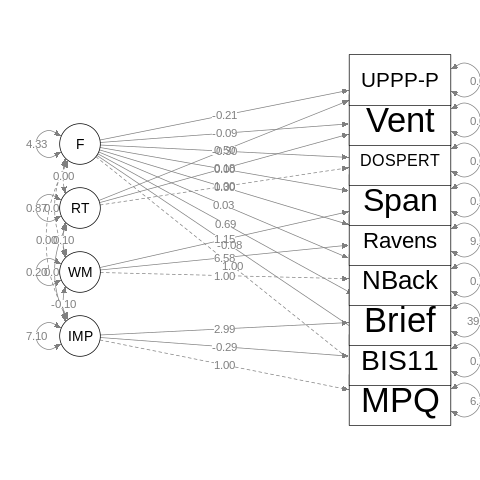

In [19]:
%%R
varnames = c('MPQ', 'BIS11', 'Brief', 'NBack', 'Ravens', 
             'Span', 'DOSPERT', 'Vent','UPPP-P', "IMP" ,"WM",  "RT", 'F' )

semPaths(bifactor_fit, "model", "est", 
         rotation=2, sizeMan =20, sizeMan2 = 10, 
         nodeLabels=varnames, edge.label.cex = 1)

We see that the model comparison suggests that the bifactor model is better.

## Cross-validation

We can also used cross-validation to assess the fit of a model to held-out data, using the same loss function that we used for fitting the model:


$$
loss = log |\Sigma| - log|\textbf{S}| + tr(\textbf{S}\Sigma^{-1}) - (p + q)
$$

To do this, let's create a python function that uses rpy2 to call lavaan:

In [44]:

nruns = 10
test_proportion = .2

r('''
fml = function(observed, implied){
 log(det(implied)) - log(det(observed)) + sum(diag(observed%*%solve(implied))) + length(diag(observed))
}''')

fml = r('''
library(lavaan)

cfa.model <- "IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking"
                    
one_factor.model <- "F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking"

bifactor.model <- "IMP =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control
               WM =~ adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span
               RT =~  dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
            
               F =~ mpq_control_survey.control + 
                    bis11_survey.Nonplanning + 
                    brief_self_control_survey.self_control + 
                    adaptive_n_back.mean_load + 
                    ravens.score + 
                    spatial_span.reverse_span + 
                    dospert_rt_survey.recreational +
                    impulsive_venture_survey.venturesomeness +
                    upps_impulsivity_survey.sensation_seeking
                    
                                        
                F         ~~ 0*WM
                F         ~~ 0*IMP
                F         ~~ 0*RT"

nruns = %d
testprop = %f
npts = nrow(cfadata)
idx = rep(0, npts)
idx[1:round(npts*testprop)] = 1
fmlresult = c()

for (i in 1:nruns){
    # split train/test
    idx = sample(idx)
    traindata = cfadata[idx==0,]
    testdata = cfadata[idx==1,]
    fit = cfa(cfa.model, data=traindata)
    fit2 = cfa(one_factor.model , data=traindata)
    fit3 = cfa(bifactor.model, data=traindata)


    test_cov = cov(testdata)
    train_cov = cov(traindata)
    implied_cov = fitted(fit)$cov
    fmlresult = rbind(fmlresult, c(fml(train_cov, fitted(fit)$cov), fml(train_cov, fitted(fit2)$cov), fml(train_cov, fitted(fit3)$cov),
            fml(test_cov, fitted(fit)$cov), fml(test_cov, fitted(fit2)$cov), fml(test_cov, fitted(fit3)$cov)))

}
''' % (nruns, test_proportion))



In [57]:
fmlresult = pd.DataFrame({'Train': r['fmlresult'].mean(0)[:3],
                          'Test': r['fmlresult'].mean(0)[3:]},
                        index=['3-factor', '1-factor', 'bifactor'])
fmlresult

,Train,Test
3-factor,18.174445,18.665081
1-factor,19.869873,20.537528
bifactor,18.055857,18.553369


Crossvalidation confirms the results from model comparison: The bifactor model has slightly lower test error compared to the CFA model, both of which handily outperform the one-factor model.


## Estimating indirect effects: "mediation analysis"

It is common to estimate indirect effects, with the goal of understanding *causal mediation*. 
Note that some methodologists think that causal mediation can only be truly assessed in situations where there is a clear causal relation between putative causes and effects, such as when there is time precedence between them.  This is not the case in many psychological studies, where the variables are assessed simultaneously and there is no experimental manipulation.  In his latest Klein states: "In general, the use of the term *mediation* should be reserved for designs that feature time precedence; otherwise, use of the term *indirect effect* is more realistic."

The model for indirect effects can be tested using SEM, which has advantages over the usual regression-based strategy: it is more flexible and also allows more appropriate handling of missing data.  In particular, it allows one to specify additional confounding variables.

Here we will look at an example using simulated data.  We will simulate an example where the X variable is manipulated (treatment vs. no treatment), and the mediator is random. 

In [116]:
# create mediation data

def create_mediation_data(a=1, b=1, c=0,
                          M_Y_error=0,
                          noise_sd=5, m_sd=1,
                          nsub_per_group=500,
                          seed=123):

    rng = np.random.RandomState(seed)

    mediationDf = pd.DataFrame({'X': np.hstack((np.zeros(nsub_per_group), 
                                                np.ones(nsub_per_group))),
                               'M_Y_confound': rng.randn(nsub_per_group*2)})
    mediationDf['M'] = mediationDf.X * a + rng.randn(nsub_per_group*2) * m_sd +\
        mediationDf.M_Y_confound * M_Y_error

    mediationDf['Y'] = mediationDf.X * c +\
        (mediationDf.X * a) * (mediationDf.M * b) +\
        rng.randn(nsub_per_group*2) * noise_sd +\
        mediationDf.M_Y_confound * M_Y_error
    
    return(mediationDf)

mediationDf = create_mediation_data()
mediationDf.corr()

,X,M_Y_confound,M,Y
X,1.000000,-0.000919,0.424706,0.061883
M_Y_confound,-0.000919,1.000000,-0.028798,-0.029056
M,0.424706,-0.028798,1.000000,0.107423
Y,0.061883,-0.029056,0.107423,1.000000


First let's look at an example where there is a true indirect effect and no true direct effect:

In [117]:
%%R -i mediationDf

mediation_formula <- ' # regressions
             M ~ a * X
             Y ~ c * X + b * M
             
              # direct effect
              direct := c

              # indirect effect
              indirect := a*b

              # total effect
              total := c + (a*b)
        
             # variances and covariances 
             X ~~ X 
             Y ~~ Y
             M ~~ M
            
             # intercepts 
             X ~ 1 
             Y ~ 1
             M ~ 1
           '

# use bootstrap to obtain standard errors
model_sem = sem(mediation_formula, data=mediationDf, se='boot', bootstrap=500)
summary(model_sem, rsq=T)  


lavaan 0.6-5 ended normally after 37 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          9
                                                      
  Number of observations                          1000
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                            Bootstrap
  Number of requested bootstrap draws              500
  Number of successful bootstrap draws             500

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)
  M ~                                                 
    X          (a)    0.898    0.061   14.627    0.000
  Y ~                                                 
    X      

This makes the correct decision.  Next let's look at a case where there is a true direct effect (c) and an effect of the mediator on Y (b), but no effect of X on the mediator(a):

In [119]:
mediationDf = create_mediation_data(a=0, c=1)


In [120]:
%%R -i mediationDf

model_sem = sem(mediation_formula, data=mediationDf, se='boot', bootstrap=500)
summary(model_sem, rsq=T)  


lavaan 0.6-5 ended normally after 36 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          9
                                                      
  Number of observations                          1000
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                            Bootstrap
  Number of requested bootstrap draws              500
  Number of successful bootstrap draws             500

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)
  M ~                                                 
    X          (a)   -0.102    0.059   -1.739    0.082
  Y ~                                                 
    X      

Again it gets the answer right.

Now let's see what happens if there is a hidden confounder on M and Y, but no true effect of the mediator:

In [121]:
mediationDf = create_mediation_data(b=0, c=1, M_Y_error=1)


In [122]:
%%R -i mediationDf

model_sem = sem(mediation_formula, data=mediationDf, se='boot', bootstrap=500)
summary(model_sem, rsq=T)  


lavaan 0.6-5 ended normally after 40 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                          9
                                                      
  Number of observations                          1000
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                            Bootstrap
  Number of requested bootstrap draws              500
  Number of successful bootstrap draws             500

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)
  M ~                                                 
    X          (a)    0.896    0.084   10.637    0.000
  Y ~                                                 
    X      

Now we see that the analysis gets the answer wrong!  In reality there is a true direct effect and no true mediated effect, but the hidden confounder causes a spurious finding of an indirect effect.  If we had a measure of this confounding effect, we could include it in the model and assess the indirect effect in the context of that confound:

In [127]:
%%R -i mediationDf

mediation_formula <- ' # regressions
             M ~ a * X + d * M_Y_confound
             Y ~ c * X + b * M + e * M_Y_confound
             
              # direct effect
              direct := c

              # indirect effect
              indirect := a*b

              # total effect
              total := c + (a*b)
        
             # variances and covariances 
             X ~~ X 
             Y ~~ Y
             M ~~ M
             # fix confound variance to 1
             M_Y_confound ~~ 1 * M_Y_confound
            
             # intercepts 
             X ~ 1 
             Y ~ 1
             M ~ 1
             M_Y_confound ~ 1
           '

# use bootstrap to obtain standard errors
model_sem = sem(mediation_formula, data=mediationDf, se='boot', bootstrap=500)
summary(model_sem, rsq=T)  


lavaan 0.6-5 ended normally after 43 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         12
                                                      
  Number of observations                          1000
                                                      
Model Test User Model:
                                                      
  Test statistic                                 0.002
  Degrees of freedom                                 2
  P-value (Chi-square)                           0.999

Parameter Estimates:

  Standard errors                            Bootstrap
  Number of requested bootstrap draws              500
  Number of successful bootstrap draws             499

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)
  M ~                                                 
    X          (a)    0.897    0.058   15.511    0.000
    M_Y_con

Now we see that the correct result is obtained once the confound is properly included in the model.